In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales = pd.read_csv("sales_data_sample.csv", encoding = "latin-1")
store_sales.head(10)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
5,10168,36,96.66,1,3479.76,10/28/2003 0:00,Shipped,4,10,2003,...,9408 Furth Circle,NaN,Burlingame,CA,94217,USA,NaN,Hirano,Juri,Medium
6,10180,29,86.13,9,2497.77,11/11/2003 0:00,Shipped,4,11,2003,...,"184, chausse de Tournai",NaN,Lille,NaN,59000,France,EMEA,Rance,Martine,Small
7,10188,48,100.00,1,5512.32,11/18/2003 0:00,Shipped,4,11,2003,...,"Drammen 121, PR 744 Sentrum",NaN,Bergen,NaN,N 5804,Norway,EMEA,Oeztan,Veysel,Medium
8,10201,22,98.57,2,2168.54,12/1/2003 0:00,Shipped,4,12,2003,...,5557 North Pendale Street,NaN,San Francisco,CA,NaN,USA,NaN,Murphy,Julie,Small
9,10211,41,100.00,14,4708.44,1/15/2004 0:00,Shipped,1,1,2004,...,"25, rue Lauriston",NaN,Paris,NaN,75016,France,EMEA,Perrier,Dominique,Medium


check for null values in the dataset

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


convert the orderdate from datatye object to datetime datatype

In [ ]:
store_sales["ORDERDATE"] = pd.to_datetime(store_sales["ORDERDATE"])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

convert orderdate to a month period, and then sum the number of items in each month

In [ ]:
#store_sales["ORDERDATE"] = store_sales["ORDERDATE"].dt.to_period("M")
monthly_sales = store_sales.groupby("ORDERDATE").sum().reset_index()

convert the resulting orderdate column to timestamo datatype

In [ ]:
#monthly_sales["ORDERDATE"] = monthly_sales["ORDERDATE"].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,ORDERDATE,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,2003-01-06,40400,151,288.78,10,12133.25,ShippedShippedShippedShipped,4,4,8012,...,2304 Long Airport Avenue2304 Long Airport Aven...,0,NashuaNashuaNashuaNashua,NHNHNHNH,62005620056200562005,USAUSAUSAUSA,0,YoungYoungYoungYoung,ValarieValarieValarieValarie,MediumMediumSmallSmall
1,2003-01-09,40404,142,284.96,10,11432.34,ShippedShippedShippedShipped,4,4,8012,...,Lyonerstr. 34Lyonerstr. 34Lyonerstr. 34Lyoners...,0,FrankfurtFrankfurtFrankfurtFrankfurt,0,60528605286052860528,GermanyGermanyGermanyGermany,EMEAEMEAEMEAEMEA,KeitelKeitelKeitelKeitel,RolandRolandRolandRoland,MediumMediumSmallSmall
2,2003-01-10,20204,80,150.14,3,6864.05,ShippedShipped,2,2,4006,...,2678 Kingston Rd.2678 Kingston Rd.,Suite 101Suite 101,NYCNYC,NYNY,1002210022,USAUSA,0,FrickFrick,MichaelMichael,MediumSmall
3,2003-01-29,161648,541,1417.54,136,54702.00,ShippedShippedShippedShippedShippedShippedShip...,16,16,32048,...,Erling Skakkes gate 78Erling Skakkes gate 78Er...,0,StavernStavernStavernStavernStavernStavernStav...,0,4110411041104110411041104110411041104110411041...,NorwayNorwayNorwayNorwayNorwayNorwayNorwayNorw...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,BergulfsenBergulfsenBergulfsenBergulfsenBergul...,JonasJonasJonasJonasJonasJonasJonasJonasJonasJ...,MediumMediumMediumMediumSmallSmallSmallSmallMe...
4,2003-01-31,131352,443,1061.89,91,44621.96,ShippedShippedShippedShippedShippedShippedShip...,13,13,26039,...,"C/ Moralzarzal, 86C/ Moralzarzal, 86C/ Moralza...",0,MadridMadridMadridMadridMadridMadridMadridMadr...,0,2803428034280342803428034280342803428034280342...,SpainSpainSpainSpainSpainSpainSpainSpainSpainS...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,FreyreFreyreFreyreFreyreFreyreFreyreFreyreFrey...,DiegoDiegoDiegoDiegoDiegoDiegoDiegoDiegoDiegoD...,MediumMediumMediumMediumMediumMediumSmallSmall...
5,2003-02-11,151575,545,1279.26,120,58871.11,ShippedShippedShippedShippedShippedShippedShip...,15,30,30045,...,Vinb'ltet 34Vinb'ltet 34Vinb'ltet 34Vinb'ltet ...,0,KobenhavnKobenhavnKobenhavnKobenhavnKobenhavnK...,0,1734173417341734173417341734173417341734173417...,DenmarkDenmarkDenmarkDenmarkDenmarkDenmarkDenm...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,PetersenPetersenPetersenPetersenPetersenPeters...,JytteJytteJytteJytteJytteJytteJytteJytteJytteJ...,LargeLargeMediumMediumMediumMediumMediumMedium...
6,2003-02-17,181908,675,1419.88,171,56181.32,ShippedShippedShippedShippedShippedShippedShip...,18,36,36054,...,Via Ludovico il Moro 22Via Ludovico il Moro 22...,0,BergamoBergamoBergamoBergamoBergamoBergamoBerg...,0,2410024100241002410024100241002410024100241002...,ItalyItalyItalyItalyItalyItalyItalyItalyItalyI...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,RovelliRovelliRovelliRovelliRovelliRovelliRove...,GiovanniGiovanniGiovanniGiovanniGiovanniGiovan...,MediumMediumMediumMediumSmallMediumSmallMedium...
7,2003-02-24,80856,229,742.41,36,25783.76,ShippedShippedShippedShippedShippedShippedShip...,8,16,16024,...,897 Long Airport Avenue897 Long Airport Avenue...,0,NYCNYCNYCNYCNYCNYCNYCNYC,NYNYNYNYNYNYNYNY,1002210022100221002210022100221002210022,USAUSAUSAUSAUSAUSAUSAUSA,0,YuYuYuYuYuYuYuYu,KwaiKwaiKwaiKwaiKwaiKwaiKwaiKwai,SmallMediumMediumMediumSmallSmallMediumSmall
8,2003-03-03,161728,561,1324.98,136,55245.02,ShippedShippedShippedShippedShippedShippedShip...,16,48,32048,...,15 McCallum Street - NatWest Center #13-0315 M...,0,Makati CityMakati CityMakati CityMakati CityMa...,0,1227 MM1227 MM1227 MM1227 MM1227 MM1227 MM1227...,PhilippinesPhilippinesPhilippinesPhilippinesPh...,JapanJapanJapanJapanJapanJapanJapanJapanJapanJ...,CruzCruzCruzCruzCruzCruzCruzCruzCruzCruzCruzCr...,ArnoldArnoldArnoldArnoldArnoldArnoldArnoldArno...,MediumMediumMediumMediumMediumSmallMediumSmall...
9,2003-03-10,60654,212,532.10,21,27398.82,ShippedShippedShipp

Visualization

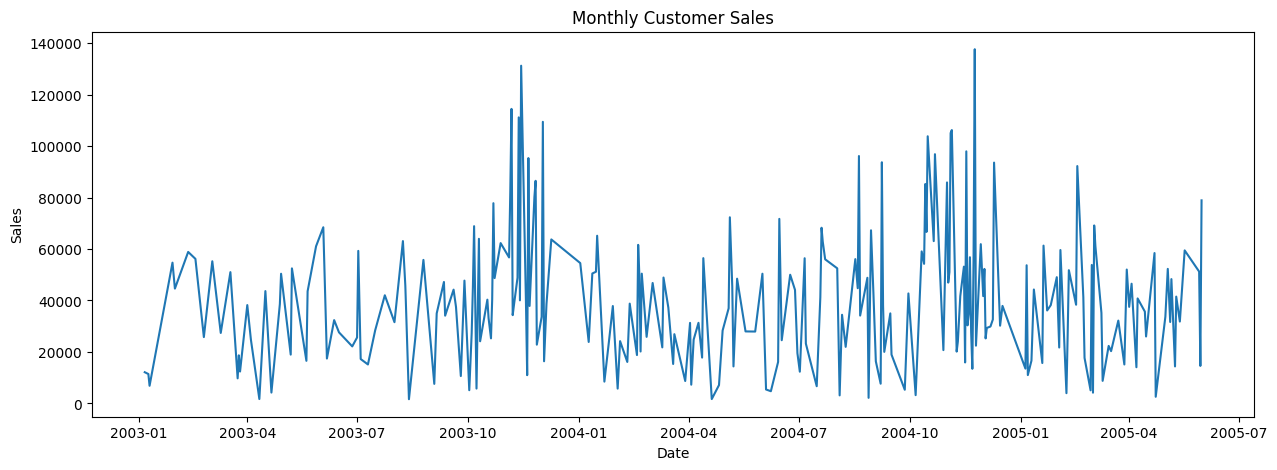

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["ORDERDATE"], monthly_sales["SALES"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

call the difference on the sales column to make the sales data stationary

In [ ]:
monthly_sales["sales_diff"] = monthly_sales["SALES"].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,ORDERDATE,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,sales_diff
1,2003-01-09,40404,142,284.96,10,11432.34,ShippedShippedShippedShipped,4,4,8012,...,0,FrankfurtFrankfurtFrankfurtFrankfurt,0,60528605286052860528,GermanyGermanyGermanyGermany,EMEAEMEAEMEAEMEA,KeitelKeitelKeitelKeitel,RolandRolandRolandRoland,MediumMediumSmallSmall,-700.91
2,2003-01-10,20204,80,150.14,3,6864.05,ShippedShipped,2,2,4006,...,Suite 101Suite 101,NYCNYC,NYNY,1002210022,USAUSA,0,FrickFrick,MichaelMichael,MediumSmall,-4568.29
3,2003-01-29,161648,541,1417.54,136,54702.00,ShippedShippedShippedShippedShippedShippedShip...,16,16,32048,...,0,StavernStavernStavernStavernStavernStavernStav...,0,4110411041104110411041104110411041104110411041...,NorwayNorwayNorwayNorwayNorwayNorwayNorwayNorw...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,BergulfsenBergulfsenBergulfsenBergulfsenBergul...,JonasJonasJonasJonasJonasJonasJonasJonasJonasJ...,MediumMediumMediumMediumSmallSmallSmallSmallMe...,47837.95
4,2003-01-31,131352,443,1061.89,91,44621.96,ShippedShippedShippedShippedShippedShippedShip...,13,13,26039,...,0,MadridMadridMadridMadridMadridMadridMadridMadr...,0,2803428034280342803428034280342803428034280342...,SpainSpainSpainSpainSpainSpainSpainSpainSpainS...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,FreyreFreyreFreyreFreyreFreyreFreyreFreyreFrey...,DiegoDiegoDiegoDiegoDiegoDiegoDiegoDiegoDiegoD...,MediumMediumMediumMediumMediumMediumSmallSmall...,-10080.04
5,2003-02-11,151575,545,1279.26,120,58871.11,ShippedShippedShippedShippedShippedShippedShip...,15,30,30045,...,0,KobenhavnKobenhavnKobenhavnKobenhavnKobenhavnK...,0,1734173417341734173417341734173417341734173417...,DenmarkDenmarkDenmarkDenmarkDenmarkDenmarkDenm...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,PetersenPetersenPetersenPetersenPetersenPeters...,JytteJytteJytteJytteJytteJytteJytteJytteJytteJ...,LargeLargeMediumMediumMediumMediumMediumMedium...,14249.15
6,2003-02-17,181908,675,1419.88,171,56181.32,ShippedShippedShippedShippedShippedShippedShip...,18,36,36054,...,0,BergamoBergamoBergamoBergamoBergamoBergamoBerg...,0,2410024100241002410024100241002410024100241002...,ItalyItalyItalyItalyItalyItalyItalyItalyItalyI...,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,RovelliRovelliRovelliRovelliRovelliRovelliRove...,GiovanniGiovanniGiovanniGiovanniGiovanniGiovan...,MediumMediumMediumMediumSmallMediumSmallMedium...,-2689.79
7,2003-02-24,80856,229,742.41,36,25783.76,ShippedShippedShippedShippedShippedShippedShip...,8,16,16024,...,0,NYCNYCNYCNYCNYCNYCNYCNYC,NYNYNYNYNYNYNYNY,1002210022100221002210022100221002210022,USAUSAUSAUSAUSAUSAUSAUSA,0,YuYuYuYuYuYuYuYu,KwaiKwaiKwaiKwaiKwaiKwaiKwaiKwai,SmallMediumMediumMediumSmallSmallMediumSmall,-30397.56
8,2003-03-03,161728,561,1324.98,136,55245.02,ShippedShippedShippedShippedShippedShippedShip...,16,48,32048,...,0,Makati CityMakati CityMakati CityMakati CityMa...,0,1227 MM1227 MM1227 MM1227 MM1227 MM1227 MM1227...,PhilippinesPhilippinesPhilippinesPhilippinesPh...,JapanJapanJapanJapanJapanJapanJapanJapanJapanJ...,CruzCruzCruzCruzCruzCruzCruzCruzCruzCruzCruzCr...,ArnoldArnoldArnoldArnoldArnoldArnoldArnoldArno...,MediumMediumMediumMediumMediumSmallMediumSmall...,29461.26
9,2003-03-10,60654,212,532.10,21,27398.82,ShippedShippedShippedShippedShippedShipped,6,18,12018,...,0,PhiladelphiaPhiladelphiaPhiladelphiaPhiladelph...,PAPAPAPAPAPA,712707127071270712707127071270,USAUSAUSAUSAUSAUSA,0,HernandezHernandezHernandezHernandezHernandezH...,RosaRosaRosaRosaRosaRosa,MediumMediumMediumLargeMediumSmall,-27846.20
10,2003-03-18,161760,570,1211.53,136,51017.92,ShippedShippedShippedShippedShippedShippedShip...,16,48,32048,...,0,ManchesterManchesterManchesterManchesterManche...,0,EC2 5NTEC2 5NTEC2 5NTEC2 5NTEC2 5NTEC2 5NTEC2 ...,UKUKUKUKUKUKUKUKUKUKUKUKUKUKUKUK,EMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEMEAEM...,AshworthAshworthAshw

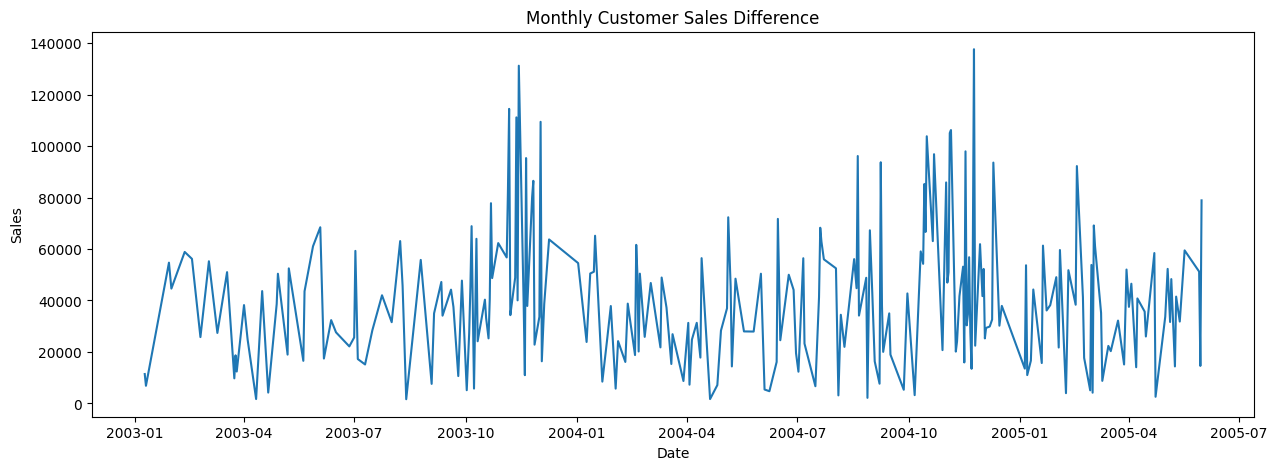

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["ORDERDATE"], monthly_sales["SALES"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

Dropping of sales and date

In [ ]:
supervised_data = monthly_sales.drop(["ORDERDATE", "SALES"], axis=1)

preparing the supervised data

In [ ]:
for i in range(1,13):
  col_name = "month_" + str(i)
  supervised_data[col_name] = supervised_data["sales_diff"].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,40452,143,318.33,10,ShippedShippedShippedShipped,4,12,8012,Trucks and BusesTrucks and BusesVintage CarsTr...,366,...,23619.10,-27846.20,29461.26,-30397.56,-2689.79,14249.15,-10080.04,47837.95,-4568.29,-700.91
1,101140,351,854.46,55,ShippedShippedShippedShippedShippedShippedShip...,20,40,20030,Classic CarsTrucks and BusesTrucks and BusesCl...,1032,...,-41268.92,23619.10,-27846.20,29461.26,-30397.56,-2689.79,14249.15,-10080.04,47837.95,-4568.29
2,50575,210,469.36,15,ShippedShippedShippedShippedShipped,10,20,10015,Trucks and BusesClassic CarsClassic CarsClassi...,571,...,8946.58,-41268.92,23619.10,-27846.20,29461.26,-30397.56,-2689.79,14249.15,-10080.04,47837.95
3,10116,27,63.38,1,Shipped,2,4,2003,Trains,62,...,-6297.02,8946.58,-41268.92,23619.10,-27846.20,29461.26,-30397.56,-2689.79,14249.15,-10080.04
4,121404,402,1049.21,78,ShippedShippedShippedShippedShippedShippedShip...,24,48,24036,Classic CarsClassic CarsClassic CarsVintage Ca...,1416,...,25818.85,-6297.02,8946.58,-41268.92,23619.10,-27846.20,29461.26,-30397.56,-2689.79,14249.15
5,10118,36,100.00,1,Shipped,2,4,2003,Ships,100,...,-13440.00,25818.85,-6297.02,8946.58,-41268.92,23619.10,-27846.20,29461.26,-30397.56,-2689.79
6,141666,442,1114.01,105,ShippedShippedShippedShippedShippedShippedShip...,28,56,28042,Classic CarsPlanesShipsVintage CarsPlanesVinta...,1207,...,-23066.15,-13440.00,25818.85,-6297.02,8946.58,-41268.92,23619.10,-27846.20,29461.26,-30397.56
7,151800,525,1274.69,120,ShippedShippedShippedShippedShippedShippedShip...,30,60,30045,MotorcyclesMotorcyclesPlanesMotorcyclesMotorcy...,1422,...,41946.21,-23066.15,-13440.00,25818.85,-6297.02,8946.58,-41268.92,23619.10,-27846.20,29461.26
8,50605,185,419.82,15,ShippedShippedShippedShippedShipped,10,25,10015,MotorcyclesMotorcyclesMotorcyclesMotorcyclesMo...,497,...,-39438.27,41946.21,-23066.15,-13440.00,25818.85,-6297.02,8946.58,-41268.92,23619.10,-27846.20
9,172074,545,1355.92,153,ShippedShippedShippedShippedShippedShippedShip...,34,85,34051,Classic CarsClassic CarsClassic CarsClassic Ca...,1828,...,34409.94,-39438.27,41946.21,-23066.15,-13440.00,25818.85,-6297.02,8946.58,-41268.92,23619.10


Spli the data into Train and Test

In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (227, 36)
Test Data Shape:  (12, 36)


In [ ]:
columns_to_drop = ["STATUS", "CUSTOMERNAME", 'PHONE', "ADDRESSLINE1", "ADDRESSLINE2", "CITY", "STATE", "POSTALCODE", "COUNTRY", "TERRITORY", "CONTACTLASTNAME", "CONTACTFIRSTNAME", "DEALSIZE", "PRODUCTLINE"]


train_features = train_data.drop(["sales_diff"] + columns_to_drop, axis=1, errors="ignore")
test_features = test_data.drop(["sales_diff"] + columns_to_drop, axis=1, errors="ignore")

train_features = train_features.select_dtypes(include=[np.number])
test_features = test_features.select_dtypes(include=[np.number])

train_target = train_data["sales_diff"]
test_target = test_data["sales_diff"]

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_features)

train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

target_scaler = MinMaxScaler(feature_range=(-1,1))
target_scaler.fit(train_target.values.reshape(-1,1))

train_target = target_scaler.transform(train_target.values.reshape(-1,1))
test_target = target_scaler.transform(test_target.values.reshape(-1,1))

In [ ]:
x_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0:1]
x_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0:1]
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
print("X_train Shape: ", x_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", x_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (227, 35)
y_train Shape:  (227,)
X_test Shape:  (12, 35)
y_test Shape:  (12,)


Make prediction data frame to merge the predicted sales prices of all trained algs

In [ ]:
sales_dates = monthly_sales["ORDERDATE"][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales["SALES"][-13:].to_list()
print(act_sales)

[58437.04, 2587.58, 33692.97, 52287.74, 31648.47, 48316.89, 14378.09, 41509.94, 31821.9, 59475.1, 51233.18, 14578.75, 78918.03]


To create the linear regression model, and predicted output

In [ ]:
lr_model = LinearRegression()
lr_model.fit(train_features_scaled, train_target)
lr_pre = lr_model.predict(test_features_scaled)

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
#lr_pre_test_set = np.concatenate([lr_pre, test_features_scaled], axis=1)
lr_pre_actual_scale = target_scaler.inverse_transform(lr_pre)

In [ ]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index= True)

In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"], monthly_sales["SALES"][-12:]))
lr_mae = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales["SALES"][-12:])
lr_r2 = r2_score(predict_df["Linear Prediction"], monthly_sales["SALES"][-12:])
print("Linear Regression MSE: ", lr_mse )
print("Linear Regression MAE: ", lr_mae )
print("Linear Regression R2: ", lr_r2 )

Linear Regression MSE:  33458.431718926906
Linear Regression MAE:  29208.478283344335
Linear Regression R2:  -2.5231139227808934


Visualization of the prediction against the actual sales

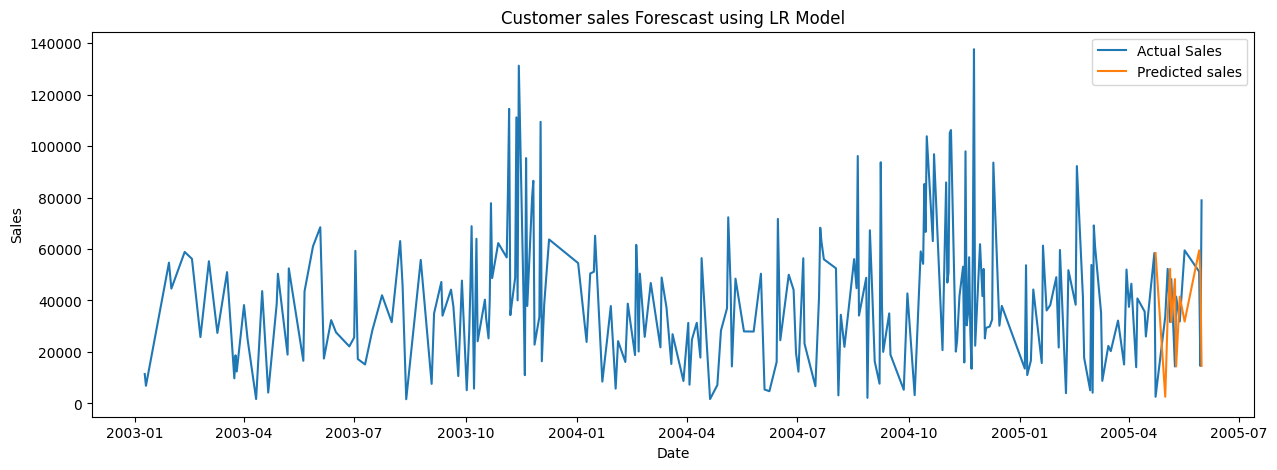

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["ORDERDATE"], monthly_sales["SALES"])
plt.plot(predict_df["ORDERDATE"], predict_df["Linear Prediction"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Customer sales Forescast using LR Model")
plt.legend(["Actual Sales", "Predicted sales"])
plt.show()